
 ## Customer Churn Analysis Project

 **Industry Context:** Telecommunications customer retention analysis


## 1. Environment Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Environment setup complete!")


✅ Environment setup complete!


In [1]:
# Generate synthetic customer churn dataset (simulating real-world data)
np.random.seed(42)  # For reproducibility

# Create sample data
n_customers = 10000

data = {
    'customer_id': [f'CUST_{i:05d}' for i in range(1, n_customers + 1)],
    'age': np.random.randint(18, 80, n_customers),
    'gender': np.random.choice(['Male', 'Female'], n_customers, p=[0.52, 0.48]),
    'tenure_months': np.random.exponential(30, n_customers).astype(int) + 1,
    'monthly_charges': np.random.normal(65, 20, n_customers),
    'total_charges': [],
    'contract_type': np.random.choice(['Month-to-month', 'One year', 'Two year'],
    n_customers, p=[0.45, 0.35, 0.20]),
    'internet_service': np.random.choice(['DSL', 'Fiber optic', 'No'], n_customers, p=[0.4, 0.45, 0.15]),
    'phone_service': np.random.choice(['Yes', 'No'], n_customers, p=[0.85, 0.15]),
    'multiple_lines': np.random.choice(['Yes', 'No', 'No phone service'],  n_customers, p=[0.4, 0.45, 0.15]),
    'online_security': np.random.choice(['Yes', 'No', 'No internet service'],   n_customers, p=[0.3, 0.55, 0.15]),
    'churn': np.random.choice(['Yes', 'No'], n_customers, p=[0.25, 0.75])
}

# Calculate total charges based on tenure and monthly charges
for i in range(n_customers):
    tenure = data['tenure_months'][i]
    monthly = max(20, data['monthly_charges'][i])  # Ensure minimum charge
    data['total_charges'].append(tenure * monthly)

# Create DataFrame
df = pd.DataFrame(data)

# Introduce realistic data quality issues (missing values, outliers, inconsistencies)
def introduce_data_issues(df):
    # Add missing values (5% random missingness)
    mask_missing = np.random.random(len(df)) < 0.05
    df.loc[mask_missing, 'monthly_charges'] = np.nan
    
    # Add outliers in age
    outlier_indices = np.random.choice(len(df), 50, replace=False)
    df.loc[outlier_indices, 'age'] = np.random.randint(100, 120, 50)
    
    # Add data type issues
    df['tenure_months'] = df['tenure_months'].astype(object)
    df.loc[np.random.choice(len(df), 100, replace=False), 'tenure_months'] = 'unknown'
    
    # Add inconsistent categorical values
    inconsistent_indices = np.random.choice(len(df), 200, replace=False)
    df.loc[inconsistent_indices, 'gender'] = np.random.choice(['M', 'F', 'Unknown'], 200)
    
    return df

df = introduce_data_issues(df)

print("📊 Dataset created with realistic data quality issues")
print(f"Dataset shape: {df.shape}")

NameError: name 'np' is not defined

In [ ]:
# Initial data inspection
print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nColumn data types:")
print(df.dtypes)

print("\nBasic statistics:")
display(df.describe())
display(df)


## 2. Data Quality Assessment Framework

In [4]:
class DataQualityAnalyzer:
    """Comprehensive data quality assessment framework"""
    
    def __init__(self, df):
        self.df = df
        self.quality_report = {}
        
    def assess_completeness(self):
        """Analyze missing values and data completeness"""
        completeness = {
            'total_rows': len(self.df),
            'total_columns': len(self.df.columns),
            'missing_values': self.df.isnull().sum().sum(),
            'completeness_rate': (1 - self.df.isnull().sum().sum() / (len(self.df) * len(self.df.columns))) * 100
        }
        
        # Per-column missingness
        missing_data = self.df.isnull().sum()
        missing_percent = (missing_data / len(self.df)) * 100
        
        completeness['missing_by_column'] = pd.DataFrame({
            'missing_count': missing_data,
            'missing_percentage': missing_percent
        }).sort_values('missing_percentage', ascending=False)
        
        return completeness
    
    def assess_data_types(self):
        """Validate data types and identify type inconsistencies"""
        type_analysis = {}
        
        for col in self.df.columns:
            type_analysis[col] = {
                'current_dtype': str(self.df[col].dtype),
                'unique_values': self.df[col].nunique(),
                'sample_values': self.df[col].dropna().head(3).tolist() if self.df[col].dtype == 'object' else None,
                'type_issues': []
            }
            
            # Detect potential type issues
            if self.df[col].dtype == 'object':
                # Check for mixed types or unexpected values
                unique_samples = self.df[col].dropna().unique()
                type_issues = []
                
                for val in unique_samples:
                    if not isinstance(val, str) and not pd.isna(val):
                        type_issues.append(f"Non-string value: {val} (type: {type(val)})")
                
                # Check for case inconsistencies
                lower_values = [str(val).lower() for val in unique_samples if isinstance(val, str)]
                if len(lower_values) != len(set(lower_values)):
                    type_issues.append("Case inconsistencies detected")
                
                type_analysis[col]['type_issues'] = type_issues
                type_analysis[col]['has_issues'] = len(type_issues) > 0
            else:
                type_analysis[col]['has_issues'] = False
        
        return type_analysis
    
    def detect_outliers(self, numerical_columns=None):
        """Identify outliers using IQR method"""
        if numerical_columns is None:
            numerical_columns = self.df.select_dtypes(include=[np.number]).columns.tolist()
        
        outlier_report = {}
        
        for col in numerical_columns:
            # Skip if column has no numerical data
            if self.df[col].dtype not in [np.int64, np.float64]:
                continue
                
            # Handle cases where column might be all NaN
            if self.df[col].notna().sum() == 0:
                outlier_report[col] = {'error': 'Column contains only NaN values'}
                continue
                
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Avoid division by zero for constant columns
            if IQR == 0:
                # Use standard deviation based approach for constant columns
                mean_val = self.df[col].mean()
                std_val = self.df[col].std()
                if std_val == 0:
                    outlier_report[col] = {'error': 'Constant column, no variability'}
                    continue
                lower_bound = mean_val - 3 * std_val
                upper_bound = mean_val + 3 * std_val
            else:
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
            
            outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)]
            
            outlier_report[col] = {
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'outlier_count': len(outliers),
                'outlier_percentage': (len(outliers) / len(self.df)) * 100,
                'min_value': self.df[col].min(),
                'max_value': self.df[col].max(),
                'has_issues': (len(outliers) / len(self.df)) * 100 > 5  # Flag if >5% outliers
            }
        
        return outlier_report
    def assess_categorical_consistency(self, categorical_columns=None):
        """Check categorical variables for consistency"""
        if categorical_columns is None:
            categorical_columns = self.df.select_dtypes(include=['object']).columns.tolist()
        
        categorical_report = {}
        
        for col in categorical_columns:
            value_counts = self.df[col].value_counts()
            inconsistencies = self._find_categorical_inconsistencies(col)
            
            categorical_report[col] = {
                'unique_values': len(value_counts),
                'value_distribution': value_counts.head(10),
                'inconsistencies': inconsistencies,
                'has_issues': len(inconsistencies) > 0
            }
        
        return categorical_report
    
    def _find_categorical_inconsistencies(self, column):
        """Find inconsistencies in categorical data"""
        if self.df[column].dtype != 'object':
            return []
            
        unique_values = self.df[column].dropna().unique()
        inconsistencies = []
        
        # Check for mixed data types
        type_counts = {}
        for val in unique_values:
            val_type = type(val).__name__
            type_counts[val_type] = type_counts.get(val_type, 0) + 1
        
        if len(type_counts) > 1:
            inconsistencies.append(f"Mixed data types: {type_counts}")
        
        # Check for case inconsistencies among string values
        string_values = [str(val).lower() for val in unique_values if isinstance(val, str)]
        if len(string_values) != len(set(string_values)):
            inconsistencies.append("Case inconsistencies detected")
        
        # Check for whitespace issues
        leading_trailing_ws = any(str(val) != str(val).strip() for val in unique_values if isinstance(val, str))
        if leading_trailing_ws:
            inconsistencies.append("Values with leading/trailing whitespace")
        
        return inconsistencies
    
    def _calculate_summary_metrics(self, completeness, data_types, outliers, categorical_consistency):
        """Calculate overall data quality score with weighted approach"""
        total_columns = len(self.df.columns)
        
        # Initialize scores
        completeness_score = 0
        type_consistency_score = 0
        outlier_score = 0
        categorical_score = 0
        
        # 1. Completeness scoring (40% weight)
        missing_df = completeness['missing_by_column']
        completeness_rates = 100 - missing_df['missing_percentage']
        completeness_score = completeness_rates.mean()
        
        # 2. Data type consistency scoring (30% weight)
        type_issues_count = sum(1 for col_info in data_types.values() 
                              if col_info.get('has_issues', False))
        type_consistency_score = 100 * (1 - type_issues_count / total_columns)
        
        # 3. Outlier scoring (20% weight) - only for numerical columns
        numerical_cols = [col for col, info in outliers.items() 
                         if 'has_issues' in info]
        if numerical_cols:
            outlier_issues = sum(1 for col in numerical_cols 
                               if outliers[col]['has_issues'])
            outlier_score = 100 * (1 - outlier_issues / len(numerical_cols))
        else:
            outlier_score = 100  # No numerical columns = perfect score
        
        # 4. Categorical consistency scoring (10% weight)
        categorical_cols = list(categorical_consistency.keys())
        if categorical_cols:
            cat_issues = sum(1 for col in categorical_cols 
                           if categorical_consistency[col]['has_issues'])
            categorical_score = 100 * (1 - cat_issues / len(categorical_cols))
        else:
            categorical_score = 100  # No categorical columns = perfect score
        
        # Weighted average
        weights = [0.4, 0.3, 0.2, 0.1]  # completeness, types, outliers, categorical
        weighted_score = (completeness_score * weights[0] + 
                         type_consistency_score * weights[1] + 
                         outlier_score * weights[2] + 
                         categorical_score * weights[3])
        
        # Count total issues for reporting
        total_issues = (
            len(missing_df[missing_df['missing_percentage'] > 10]) +  # High missingness
            type_issues_count +  # Type issues
            (outlier_issues if numerical_cols else 0) +  # Outlier issues
            (cat_issues if categorical_cols else 0)  # Categorical issues
        )
        
        return {
            'quality_score': round(weighted_score, 2),
            'total_issues_identified': total_issues,
            'component_scores': {
                'completeness': round(completeness_score, 2),
                'type_consistency': round(type_consistency_score, 2),
                'outlier_quality': round(outlier_score, 2),
                'categorical_consistency': round(categorical_score, 2)
            },
            'data_quality_rating': self._get_quality_rating(weighted_score)
        }
    
    def _get_quality_rating(self, score):
        """Convert quality score to rating"""
        if score >= 95: return "Excellent"
        elif score >= 85: return "Very Good"
        elif score >= 75: return "Good"
        elif score >= 65: return "Fair"
        elif score >= 50: return "Poor"
        else: return "Critical"
    
    def generate_quality_report(self):
        """Generate comprehensive data quality report"""
        # Calculate all components first
        completeness = self.assess_completeness()
        data_types = self.assess_data_types()
        outliers = self.detect_outliers()
        categorical_consistency = self.assess_categorical_consistency()
        
        # Now calculate summary metrics using the components
        summary_metrics = self._calculate_summary_metrics(
            completeness, data_types, outliers, categorical_consistency
        )
        
        # Build the final report
        self.quality_report = {
            'completeness': completeness,
            'data_types': data_types,
            'outliers': outliers,
            'categorical_consistency': categorical_consistency,
            'summary_metrics': summary_metrics
        }
        
        return self.quality_report
    
    def visualize_quality_report(self):
        """Create visualizations for the quality report"""
        if not self.quality_report:
            print("Please generate quality report first using generate_quality_report()")
            return
            
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Data Quality Assessment Dashboard', fontsize=16, fontweight='bold')
        
        # 1. Missing values by column
        missing_df = self.quality_report['completeness']['missing_by_column']
        axes[0,0].barh(missing_df.index, missing_df['missing_percentage'])
        axes[0,0].set_title('Missing Values by Column (%)')
        axes[0,0].set_xlabel('Missing Percentage')
        
        # 2. Data types distribution
        dtype_counts = self.df.dtypes.value_counts()
        axes[0,1].pie(dtype_counts.values, labels=dtype_counts.index, autopct='%1.1f%%')
        axes[0,1].set_title('Data Types Distribution')
        
        # 3. Outlier analysis
        outlier_data = {}
        for col, info in self.quality_report['outliers'].items():
            if 'outlier_percentage' in info:
                outlier_data[col] = info['outlier_percentage']
        
        if outlier_data:
            axes[0,2].bar(outlier_data.keys(), outlier_data.values())
            axes[0,2].set_title('Outlier Percentage by Column')
            axes[0,2].tick_params(axis='x', rotation=45)
        else:
            axes[0,2].text(0.5, 0.5, 'No numerical columns', ha='center', va='center')
            axes[0,2].set_title('Outlier Analysis')
        
        # 4. Component scores radar chart
        component_scores = self.quality_report['summary_metrics']['component_scores']
        categories = list(component_scores.keys())
        scores = list(component_scores.values())
        
        # Complete the circle
        categories += [categories[0]]
        scores += [scores[0]]
        
        angles = np.linspace(0, 2*np.pi, len(categories[:-1]), endpoint=False).tolist()
        angles += angles[:1]
        
        axes[1,0] = plt.subplot(232, polar=True)
        axes[1,0].plot(angles, scores, 'o-', linewidth=2, label='Quality Scores')
        axes[1,0].fill(angles, scores, alpha=0.25)
        axes[1,0].set_thetagrids(np.degrees(angles[:-1]), categories[:-1])
        axes[1,0].set_title('Component Quality Scores')
        axes[1,0].grid(True)
        
        # 5. Quality score gauge
        quality_score = self.quality_report['summary_metrics']['quality_score']
        self._create_gauge_chart(quality_score, axes[1,1])
        
        # 6. Issues breakdown
        issues_data = {
            'High Missingness': len(missing_df[missing_df['missing_percentage'] > 10]),
            'Type Issues': sum(1 for col_info in self.quality_report['data_types'].values() 
                             if col_info.get('has_issues', False)),
            'Outlier Issues': sum(1 for col, info in self.quality_report['outliers'].items() 
                                if info.get('has_issues', False)),
            'Categorical Issues': sum(1 for col_info in self.quality_report['categorical_consistency'].values() 
                                    if col_info.get('has_issues', False))
        }
        
        axes[1,2].bar(issues_data.keys(), issues_data.values())
        axes[1,2].set_title('Data Quality Issues by Type')
        axes[1,2].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def _create_gauge_chart(self, score, ax):
        """Create a gauge chart for quality score"""
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 1)
        
        # Color segments based on rating
        segments = [
            (0, 50, 'red'),
            (50, 65, 'orange'),
            (65, 75, 'yellow'),
            (75, 85, 'lightgreen'),
            (85, 95, 'green'),
            (95, 100, 'darkgreen')
        ]
        
        for start, end, color in segments:
            ax.barh(0.5, end-start, left=start, height=0.3, color=color, alpha=0.7)
        
        # Needle
        ax.axvline(x=score, ymin=0.4, ymax=0.6, color='black', linewidth=3)
        ax.text(score, 0.7, f'{score:.1f}%', ha='center', fontweight='bold', fontsize=12)
        ax.text(50, 0.2, self.quality_report['summary_metrics']['data_quality_rating'], 
                ha='center', fontweight='bold', fontsize=14)
        ax.set_title('Overall Data Quality Score')
        ax.axis('off')

    def print_detailed_report(self):
        """Print a detailed quality report"""
        if not self.quality_report:
            print("Please generate quality report first using generate_quality_report()")
            return
            
        metrics = self.quality_report['summary_metrics']
        
        print("="*60)
        print("DATA QUALITY ASSESSMENT REPORT")
        print("="*60)
        print(f"Overall Quality Score: {metrics['quality_score']}% - {metrics['data_quality_rating']}")
        print(f"Total Issues Identified: {metrics['total_issues_identified']}")
        print("\nComponent Scores:")
        for component, score in metrics['component_scores'].items():
            print(f"  - {component.replace('_', ' ').title()}: {score}%")
        
        print("\n🔍 KEY FINDINGS:")
        
        # Missing values analysis
        high_missing = self.quality_report['completeness']['missing_by_column']
        high_missing = high_missing[high_missing['missing_percentage'] > 10]
        if not high_missing.empty:
            print("\n❌ High Missing Values (>10%):")
            for col, row in high_missing.iterrows():
                print(f"   - {col}: {row['missing_percentage']:.1f}% missing")
        
        # Data type issues
        type_issues = [col for col, info in self.quality_report['data_types'].items() 
         if info.get('has_issues', False)]
        if type_issues:
            print("\n❌ Data Type Issues:")
            for col in type_issues:
                issues = self.quality_report['data_types'][col]['type_issues']
                print(f"   - {col}: {', '.join(issues)}")
        
        # Outlier issues
        outlier_issues = [col for col, info in self.quality_report['outliers'].items() 
                        if info.get('has_issues', False)]
        if outlier_issues:
            print("\n❌ High Outlier Count (>5%):")
            for col in outlier_issues:
                pct = self.quality_report['outliers'][col]['outlier_percentage']
                print(f"   - {col}: {pct:.1f}% outliers")
        
        print("="*60)

📋 DATA QUALITY REPORT GENERATED
Overall Quality Score: 86.2% - Very Good
Total Issues Identified: 3

🔍 Key Findings:
- Missing values: 491 total
- Columns with data type issues: 0


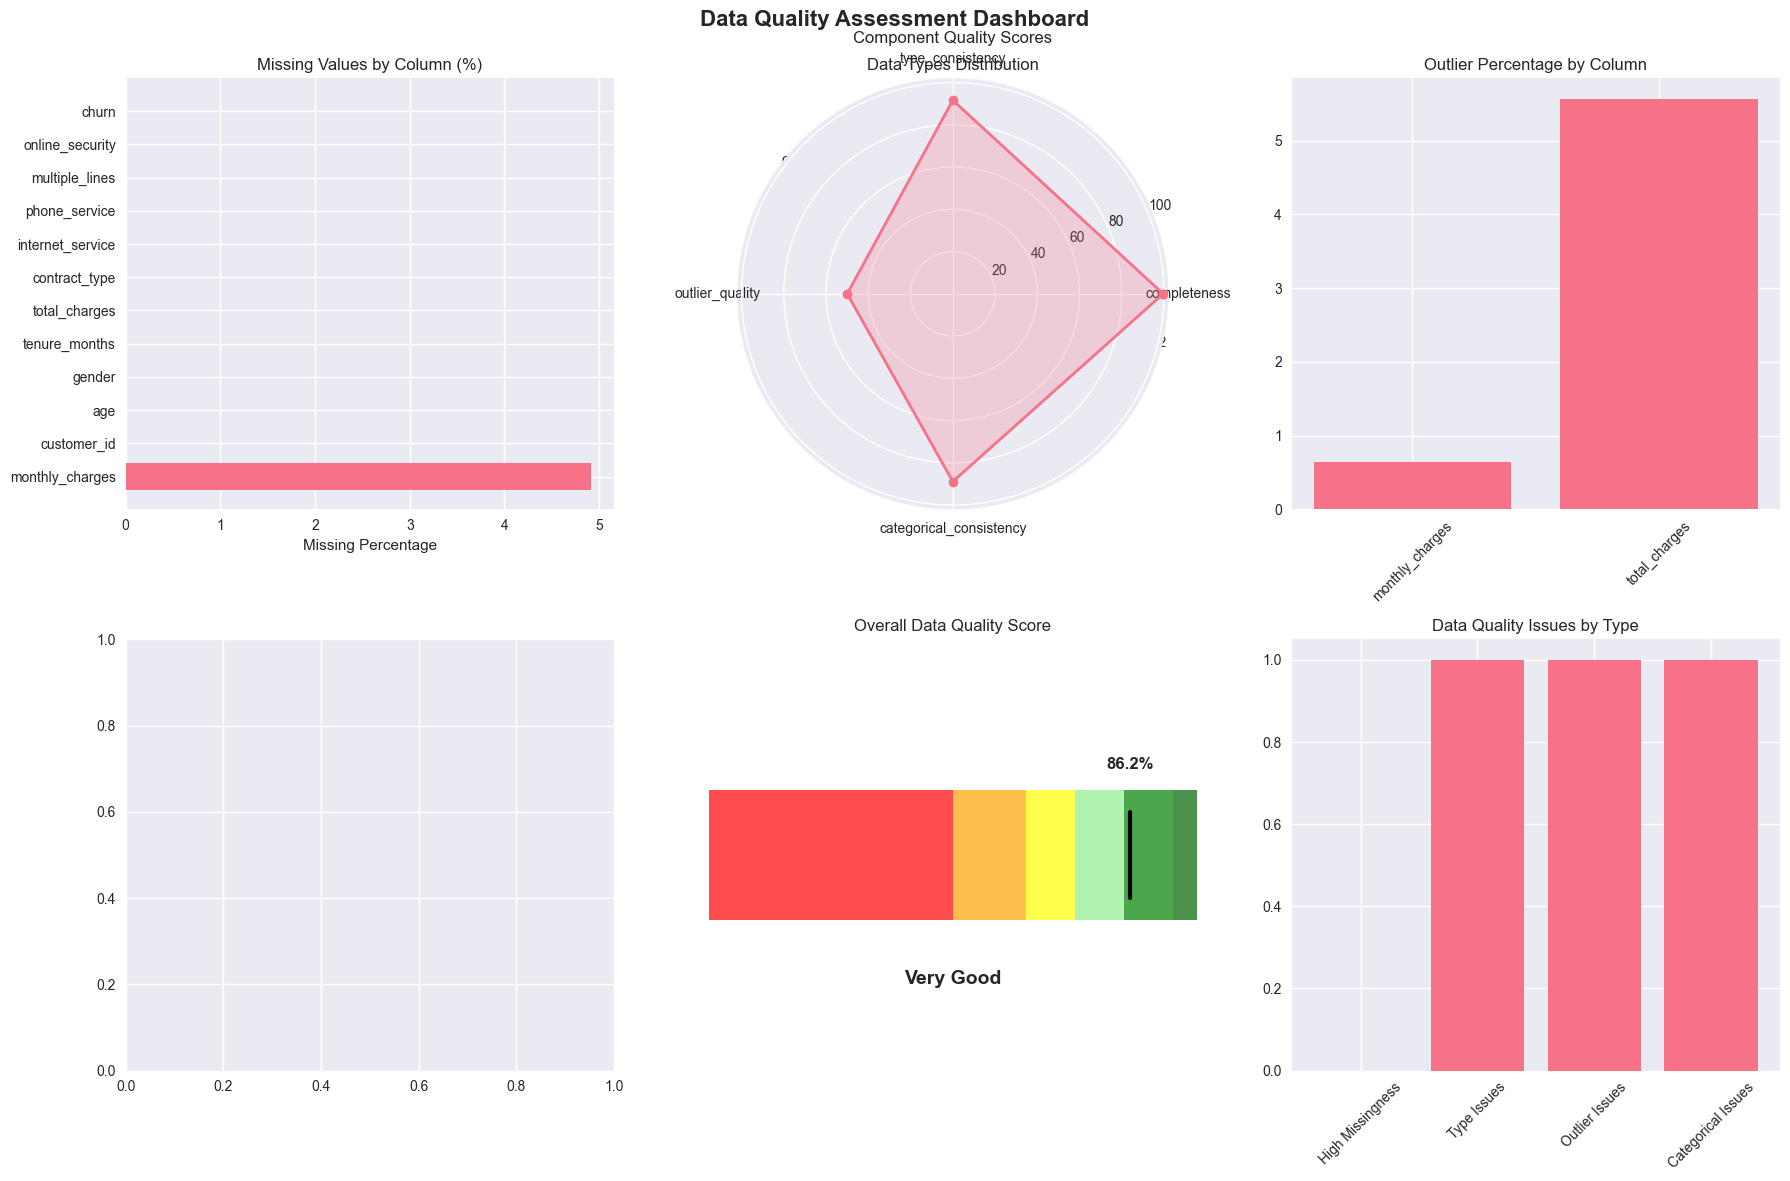

In [10]:
# Initialize data quality analyzer
quality_analyzer = DataQualityAnalyzer(df)
quality_report = quality_analyzer.generate_quality_report()

print("📋 DATA QUALITY REPORT GENERATED")
print("=" * 50)

# Display key findings
summary = quality_report['summary_metrics']
print(f"Overall Quality Score: {summary['quality_score']:.1f}% - {summary['data_quality_rating']}")
print(f"Total Issues Identified: {summary['total_issues_identified']}")

print("\n🔍 Key Findings:")
print(f"- Missing values: {quality_report['completeness']['missing_values']} total")
print(f"- Columns with data type issues: {len([k for k,v in quality_report['data_types'].items() if v.get('potential_issues')])}")

# Visualize the report
quality_analyzer.visualize_quality_report()


## 3. Data Cleaning and Transformation


In [7]:
class DataCleaner:
    """Comprehensive data cleaning pipeline"""
    
    def __init__(self, df):
        self.df = df.copy()
        self.cleaning_log = []
    
    def fix_data_types(self):
        """Convert columns to appropriate data types"""
        original_shape = self.df.shape
        
        # Fix tenure_months - convert to numeric, handle 'unknown' values
        self.df['tenure_months'] = pd.to_numeric(self.df['tenure_months'], errors='coerce')
        
        # Ensure numerical columns are properly typed
        numerical_cols = ['age', 'monthly_charges', 'total_charges', 'tenure_months']
        for col in numerical_cols:
            if col in self.df.columns:
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
        
        self.cleaning_log.append(f"Fixed data types - shape remains {original_shape}")
        return self
    
    def handle_missing_values(self):
        """Implement appropriate missing value treatment"""
        missing_before = self.df.isnull().sum().sum()
        
        # Strategy 1: Mean imputation for monthly_charges
        if 'monthly_charges' in self.df.columns:
            mean_charge = self.df['monthly_charges'].mean()
            self.df['monthly_charges'].fillna(mean_charge, inplace=True)
        
        # Strategy 2: Mode imputation for categorical (if any missing)
        categorical_cols = self.df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if self.df[col].isnull().any():
                mode_val = self.df[col].mode()[0]
                self.df[col].fillna(mode_val, inplace=True)
        
        missing_after = self.df.isnull().sum().sum()
        self.cleaning_log.append(f"Missing values handled: {missing_before} → {missing_after}")
        return self
    
    def handle_outliers(self):
        """Treat outliers using capping method"""
        numerical_cols = ['age', 'monthly_charges', 'total_charges', 'tenure_months']
        
        for col in numerical_cols:
            if col in self.df.columns:
                Q1 = self.df[col].quantile(0.05)  # Using 5th percentile for lower bound
                Q3 = self.df[col].quantile(0.95)  # Using 95th percentile for upper bound
                IQR = Q3 - Q1
                
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                # Cap outliers
                self.df[col] = np.where(self.df[col] < lower_bound, lower_bound, self.df[col])
                self.df[col] = np.where(self.df[col] > upper_bound, upper_bound, self.df[col])
        
        self.cleaning_log.append("Outliers handled using winsorization")
        return self
    
    def standardize_categorical_values(self):
        """Standardize categorical variable values"""
        # Fix gender inconsistencies
        gender_mapping = {'M': 'Male', 'F': 'Female', 'Unknown': 'Female'}  # Assume Unknown → Female
        if 'gender' in self.df.columns:
            self.df['gender'] = self.df['gender'].map(gender_mapping).fillna(self.df['gender'])
        
        # Ensure consistent case for all categorical variables
        categorical_cols = self.df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if col not in ['customer_id']:  # Skip ID columns
                self.df[col] = self.df[col].astype(str).str.title()
        
        self.cleaning_log.append("Categorical values standardized")
        return self
    
    def create_new_features(self):
        """Create derived features for analysis"""
        # Create tenure segments
        conditions = [
            (self.df['tenure_months'] <= 12),
            (self.df['tenure_months'] <= 24),
            (self.df['tenure_months'] > 24)
        ]
        choices = ['Short-term (<1yr)', 'Medium-term (1-2yrs)', 'Long-term (>2yrs)']
        self.df['tenure_segment'] = np.select(conditions, choices, default='Unknown')
        
        # Create age groups
        bins = [0, 30, 45, 60, 100]
        labels = ['18-30', '31-45', '46-60', '60+']
        self.df['age_group'] = pd.cut(self.df['age'], bins=bins, labels=labels, right=False)
        
        # Create monthly charge segments
        self.df['charge_segment'] = pd.qcut(self.df['monthly_charges'], q=3, 
                                          labels=['Low', 'Medium', 'High'])
        
        self.cleaning_log.append("Created 3 new derived features")
        return self
    
    def get_cleaning_report(self):
        """Generate cleaning summary report"""
        report = {
            'original_issues': len([msg for msg in self.cleaning_log if "before" in msg]),
            'actions_taken': self.cleaning_log,
            'final_shape': self.df.shape,
            'remaining_missing': self.df.isnull().sum().sum()
        }
        return report
    
    def get_clean_data(self):
        """Return the cleaned dataset"""
        return self.df


In [8]:
# Execute data cleaning pipeline
print("🧹 STARTING DATA CLEANING PIPELINE")
print("=" * 40)

cleaner = DataCleaner(df)

# Execute all cleaning steps
cleaner.fix_data_types()
cleaner.handle_missing_values()
cleaner.handle_outliers()
cleaner.standardize_categorical_values()
cleaner.create_new_features()

# Get cleaned data
df_clean = cleaner.get_clean_data()

# Generate cleaning report
cleaning_report = cleaner.get_cleaning_report()

print("✅ DATA CLEANING COMPLETED")
print("\nCleaning Actions Taken:")
for action in cleaning_report['actions_taken']:
    print(f"  - {action}")

print(f"\nFinal dataset shape: {cleaning_report['final_shape']}")
print(f"Remaining missing values: {cleaning_report['remaining_missing']}")

# Compare before and after
print("\n📊 BEFORE vs AFTER CLEANING")
print("Missing values:")
print(f"  Before: {df.isnull().sum().sum()}")
print(f"  After:  {df_clean.isnull().sum().sum()}")

print("\nData types issues resolved:")
print(f"  tenure_months dtype: {df['tenure_months'].dtype} → {df_clean['tenure_months'].dtype}")


🧹 STARTING DATA CLEANING PIPELINE
✅ DATA CLEANING COMPLETED

Cleaning Actions Taken:
  - Fixed data types - shape remains (10000, 12)
  - Missing values handled: 591 → 100
  - Outliers handled using winsorization
  - Categorical values standardized
  - Created 3 new derived features

Final dataset shape: (10000, 15)
Remaining missing values: 150

📊 BEFORE vs AFTER CLEANING
Missing values:
  Before: 491
  After:  150

Data types issues resolved:
  tenure_months dtype: object → float64


## 4. Exploratory Data Analysis (EDA)

In [9]:
class EDAVisualizer:
    """Comprehensive exploratory data analysis with visualizations"""
    
    def __init__(self, df):
        self.df = df
    
    def plot_demographic_distribution(self):
        """Visualize customer demographic distributions"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Customer Demographic Analysis', fontsize=16, fontweight='bold')
        
        # Age distribution
        axes[0,0].hist(self.df['age'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].set_xlabel('Age')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].set_title('Age Distribution')
        axes[0,0].grid(True, alpha=0.3)
        
        # Gender distribution
        gender_counts = self.df['gender'].value_counts()
        axes[0,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', 
                     colors=['lightcoral', 'lightblue'])
        axes[0,1].set_title('Gender Distribution')
        
        # Tenure distribution
        tenure_segment_counts = self.df['tenure_segment'].value_counts()
        axes[1,0].bar(tenure_segment_counts.index, tenure_segment_counts.values, color='lightgreen')
        axes[1,0].set_title('Tenure Segment Distribution')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Monthly charges distribution
        axes[1,1].hist(self.df['monthly_charges'], bins=30, alpha=0.7, color='gold', edgecolor='black')
        axes[1,1].set_xlabel('Monthly Charges ($)')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Monthly Charges Distribution')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_churn_analysis(self):
        """Analyze churn patterns and correlations"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Churn Analysis', fontsize=16, fontweight='bold')
        
        # Overall churn rate
        churn_counts = self.df['churn'].value_counts()
        axes[0,0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%',
                     colors=['lightgreen', 'lightcoral'])
        axes[0,0].set_title('Overall Churn Rate')
        
        # Churn by tenure
        churn_by_tenure = pd.crosstab(self.df['tenure_segment'], self.df['churn'], normalize='index') * 100
        churn_by_tenure.plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'lightcoral'])
        axes[0,1].set_title('Churn Rate by Tenure Segment')
        axes[0,1].set_ylabel('Percentage (%)')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].legend(title='Churn')
        
        # Churn by monthly charges
        sns.boxplot(data=self.df, x='churn', y='monthly_charges', ax=axes[1,0], 
                   palette=['lightgreen', 'lightcoral'])
        axes[1,0].set_title('Monthly Charges vs Churn')
        axes[1,0].set_xlabel('Churn Status')
        axes[1,0].set_ylabel('Monthly Charges ($)')
        
        # Churn by contract type
        churn_by_contract = pd.crosstab(self.df['contract_type'], self.df['churn'], normalize='index') * 100
        churn_by_contract.plot(kind='bar', ax=axes[1,1], color=['lightgreen', 'lightcoral'])
        axes[1,1].set_title('Churn Rate by Contract Type')
        axes[1,1].set_ylabel('Percentage (%)')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].legend(title='Churn')
        
        plt.tight_layout()
        plt.show()
    
    def plot_service_analysis(self):
        """Analyze service usage patterns"""
        service_columns = ['internet_service', 'phone_service', 'multiple_lines', 'online_security']
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Service Usage Analysis', fontsize=16, fontweight='bold')
        
        for i, service in enumerate(service_columns):
            row, col = i // 2, i % 2
            
            # Service distribution with churn overlay
            service_churn = pd.crosstab(self.df[service], self.df['churn'], normalize='index') * 100
            
            if len(service_churn) > 0:
                service_churn.plot(kind='bar', ax=axes[row, col], 
                                 color=['lightgreen', 'lightcoral'])
                axes[row, col].set_title(f'Churn by {service.replace("_", " ").title()}')
                axes[row, col].set_ylabel('Percentage (%)')
                axes[row, col].tick_params(axis='x', rotation=45)
                axes[row, col].legend(title='Churn')
        
        plt.tight_layout()
        plt.show()
    
    def correlation_analysis(self):
        """Analyze correlations between numerical variables"""
        numerical_cols = ['age', 'tenure_months', 'monthly_charges', 'total_charges']
        
        # Calculate correlation matrix
        corr_matrix = self.df[numerical_cols].corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5)
        plt.title('Correlation Matrix of Numerical Variables')
        plt.tight_layout()
        plt.show()
        
        return corr_matrix
    
    def generate_eda_summary(self):
        """Generate comprehensive EDA summary"""
        print("📈 EXPLORATORY DATA ANALYSIS SUMMARY")
        print("=" * 50)
        
        # Basic statistics
        print(f"Total customers: {len(self.df):,}")
        print(f"Overall churn rate: {(self.df['churn'] == 'Yes').mean() * 100:.1f}%")
        print(f"Average tenure: {self.df['tenure_months'].mean():.1f} months")
        print(f"Average monthly charge: ${self.df['monthly_charges'].mean():.2f}")
        
        # Key insights
        print("\n🔑 KEY INSIGHTS:")
        
        # Churn by contract type
        contract_churn = self.df.groupby('contract_type')['churn'].apply(
            lambda x: (x == 'Yes').mean() * 100
        ).sort_values(ascending=False)
        
        print(f"1. Highest churn rate: {contract_churn.index[0]} contracts ({contract_churn.iloc[0]:.1f}%)")
        
        # Tenure vs churn
        short_tenure_churn = (self.df[self.df['tenure_segment'] == 'Short-term (<1yr)']['churn'] == 'Yes').mean() * 100
        print(f"2. Short-term customers churn rate: {short_tenure_churn:.1f}%")
        
        # Service impact
        fiber_churn = (self.df[self.df['internet_service'] == 'Fiber Optic']['churn'] == 'Yes').mean() * 100
        dsl_churn = (self.df[self.df['internet_service'] == 'Dsl']['churn'] == 'Yes').mean() * 100
        print(f"3. Fiber optic vs DSL churn: {fiber_churn:.1f}% vs {dsl_churn:.1f}%")


🔍 STARTING EXPLORATORY DATA ANALYSIS


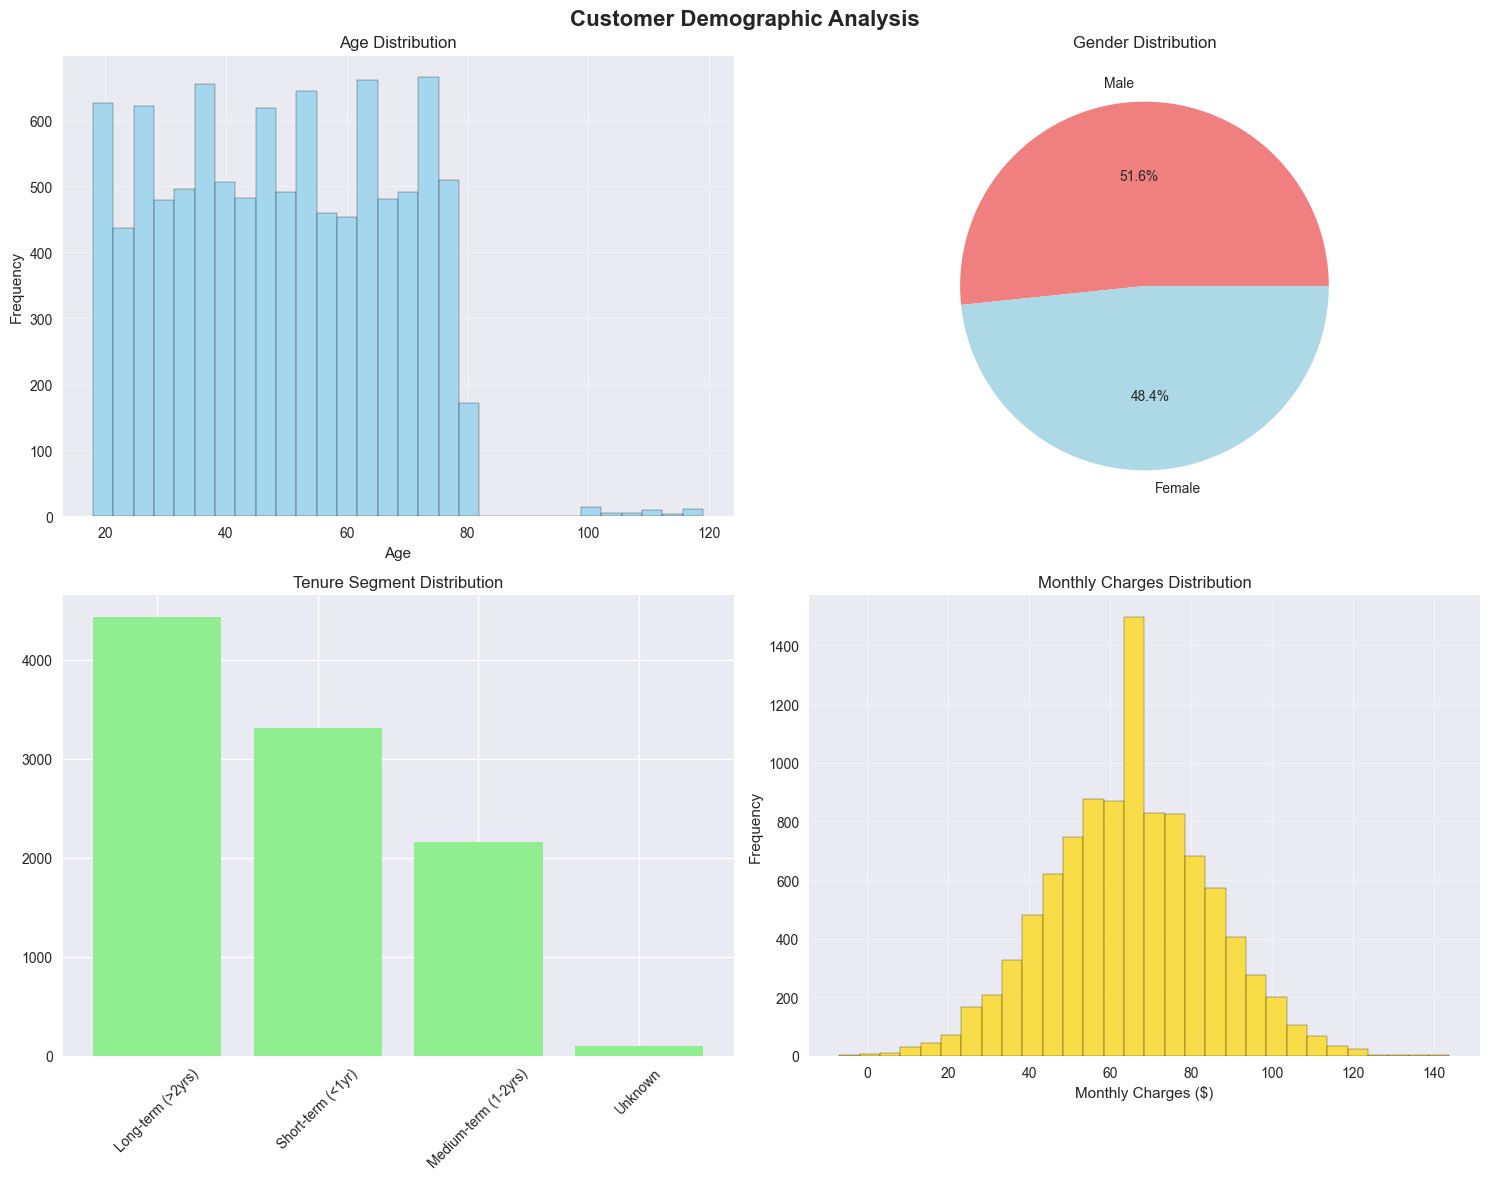

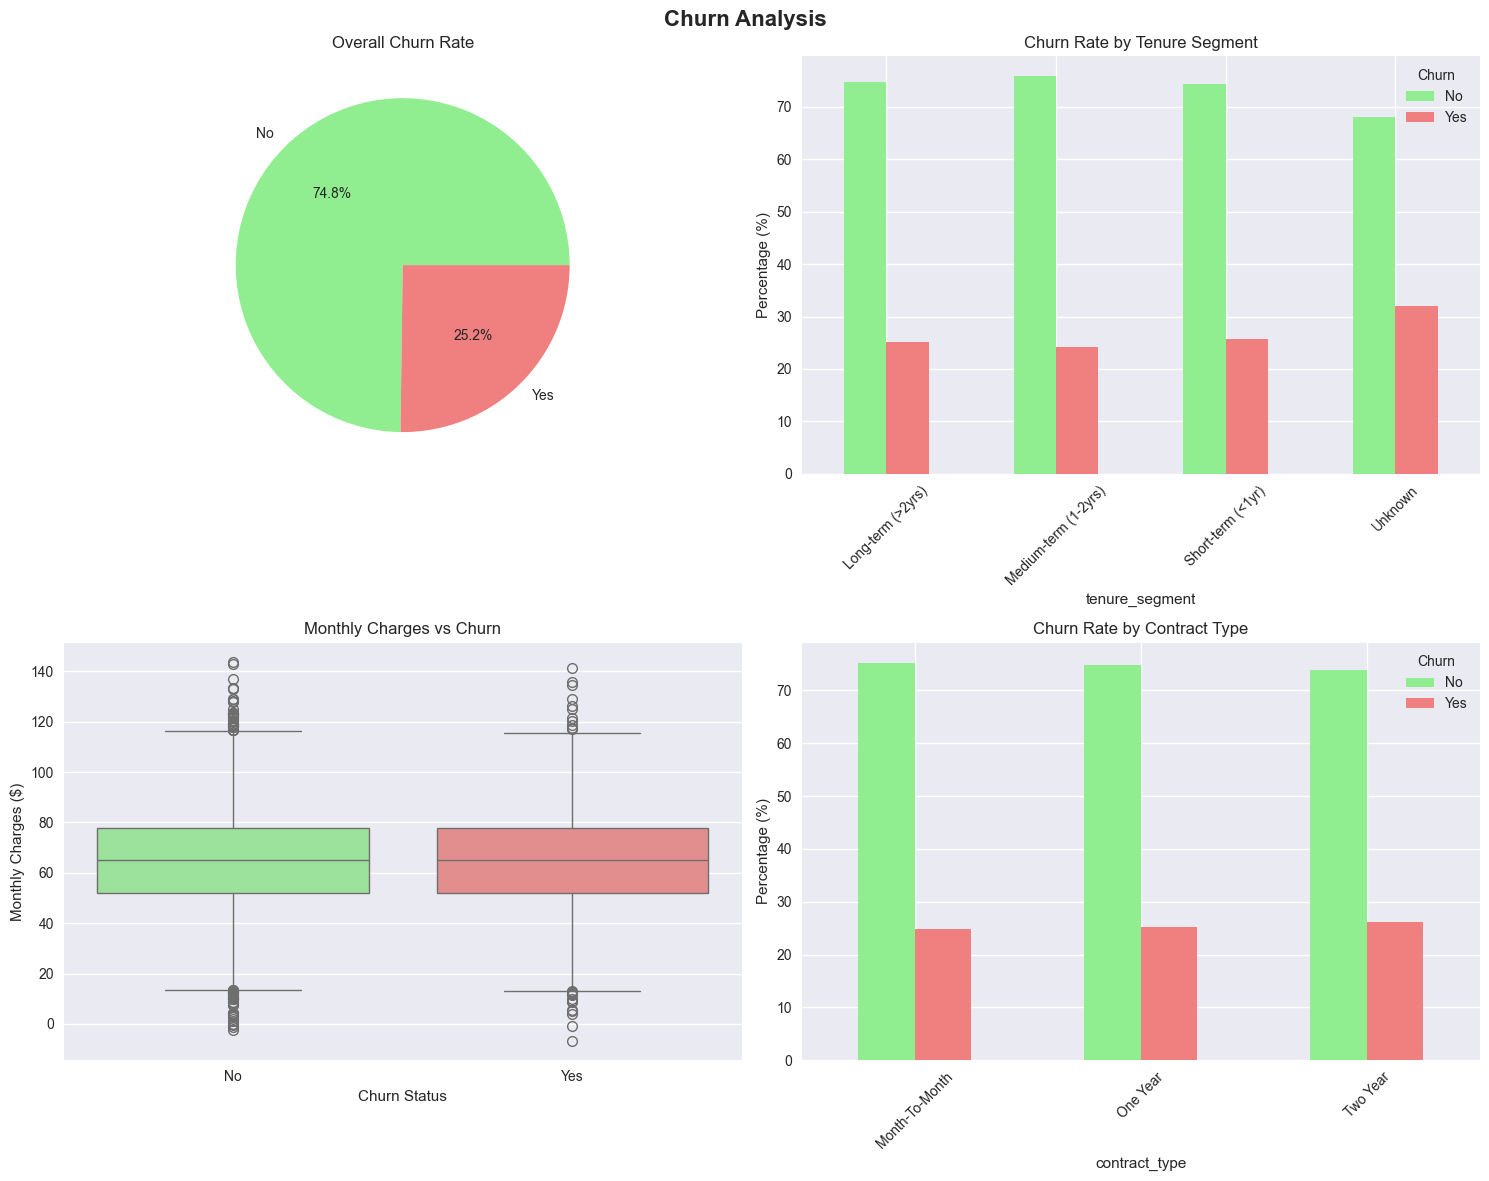

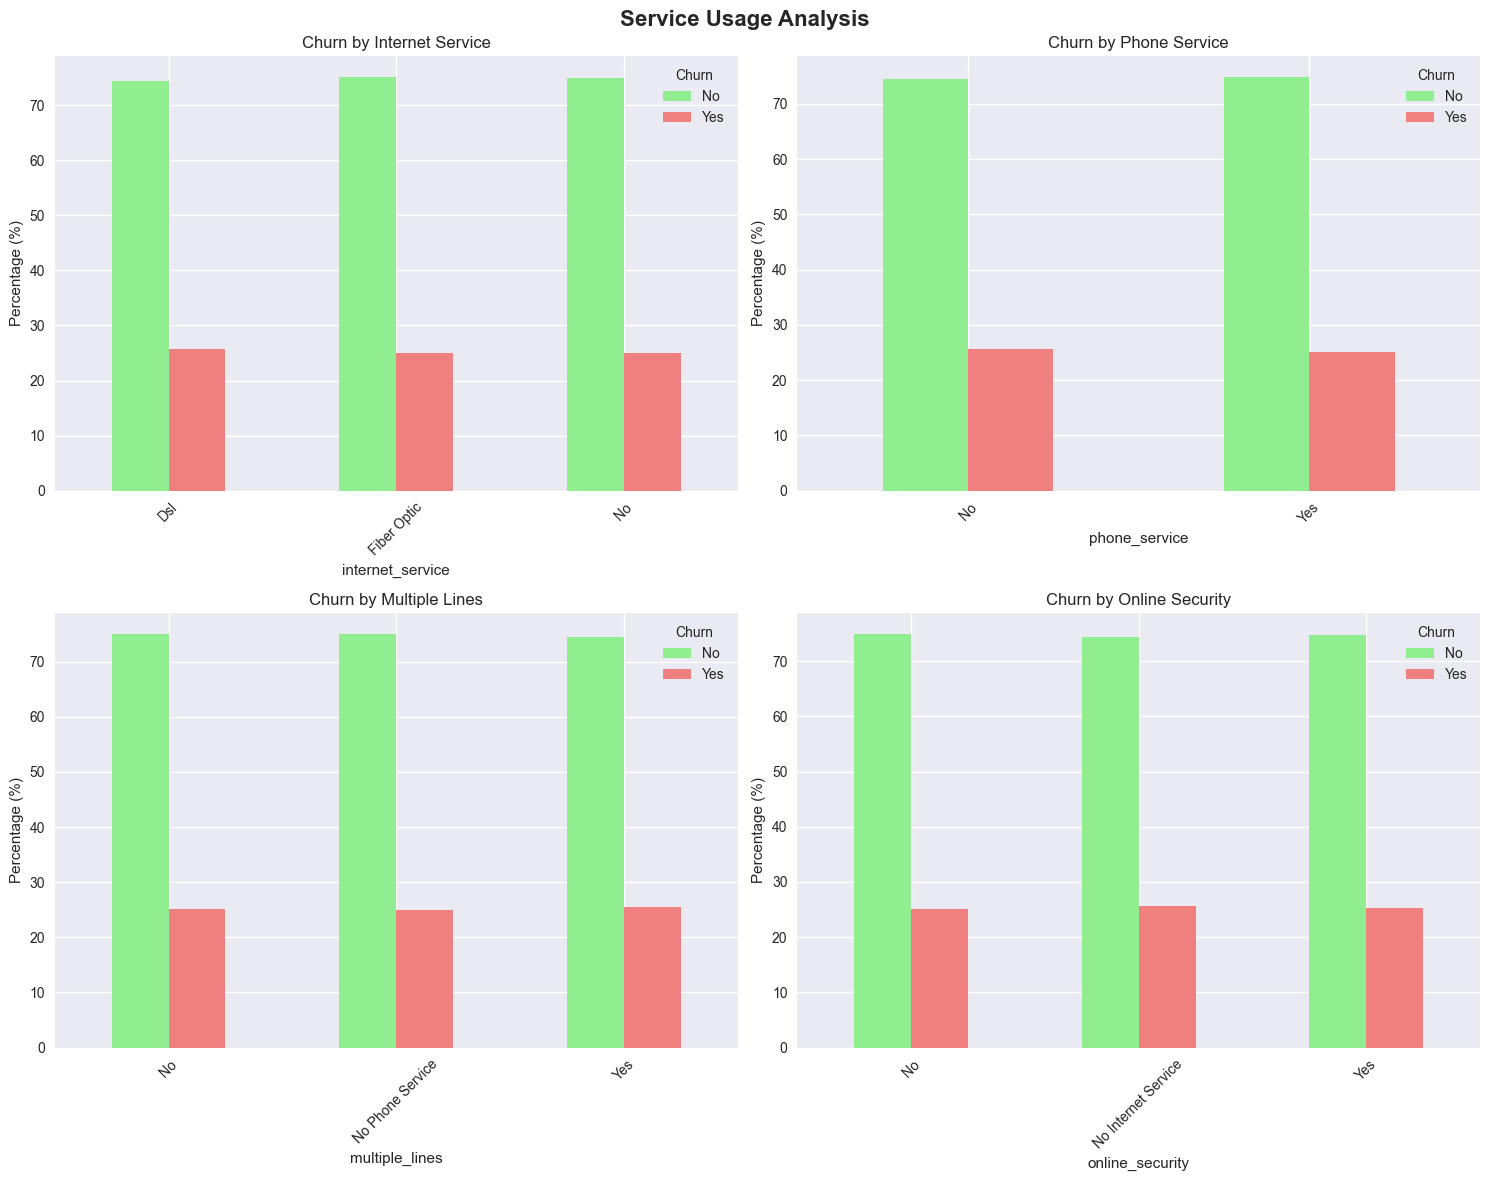

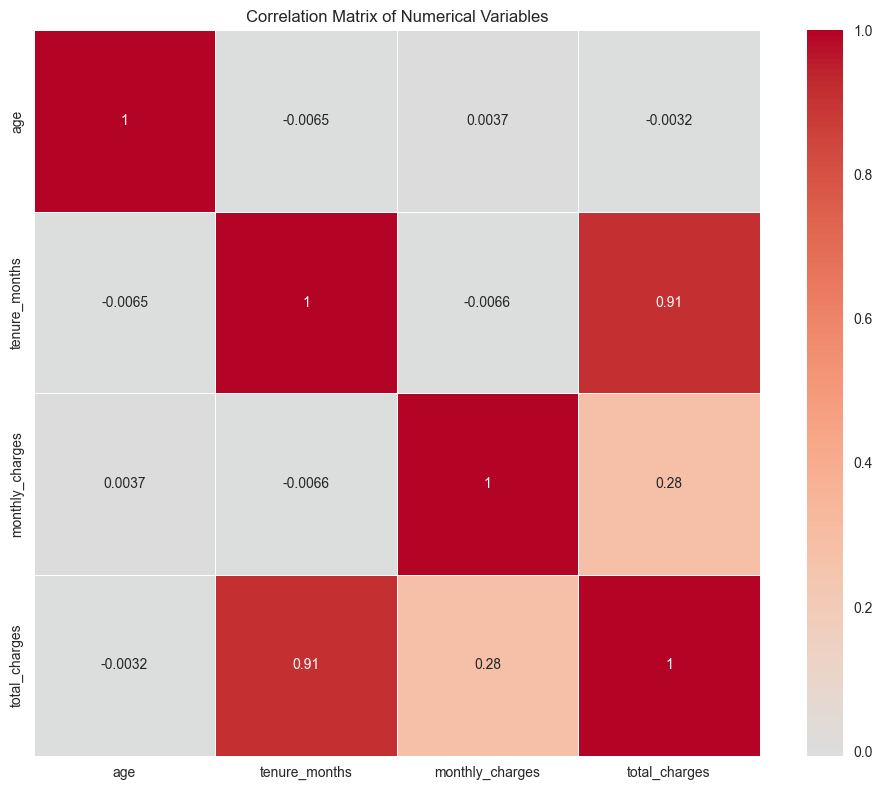

📈 EXPLORATORY DATA ANALYSIS SUMMARY
Total customers: 10,000
Overall churn rate: 25.2%
Average tenure: 30.4 months
Average monthly charge: $64.90

🔑 KEY INSIGHTS:
1. Highest churn rate: Two Year contracts (26.1%)
2. Short-term customers churn rate: 25.7%
3. Fiber optic vs DSL churn: 24.9% vs 25.6%


In [13]:
# Perform comprehensive EDA
print("🔍 STARTING EXPLORATORY DATA ANALYSIS")
eda = EDAVisualizer(df_clean)

# Generate all visualizations
eda.plot_demographic_distribution()
eda.plot_churn_analysis()
eda.plot_service_analysis()
correlation_matrix = eda.correlation_analysis()

# Generate summary insights
eda.generate_eda_summary()


## 5. Advanced Analysis: Customer Segmentation

🎯 CUSTOMER SEGMENTATION ANALYSIS


,churn,monthly_charges,tenure_months,count,percentage
customer_segment,,,,,
At-Risk High Value,26.47,84.30,172.99,34,0.34
Champions,10.00,98.58,154.10,10,0.10
Critical,25.11,64.73,26.01,8516,85.16
Low Value Loyal,25.45,65.11,53.64,1340,13.40
Other,32.00,66.62,NaN,100,1.00


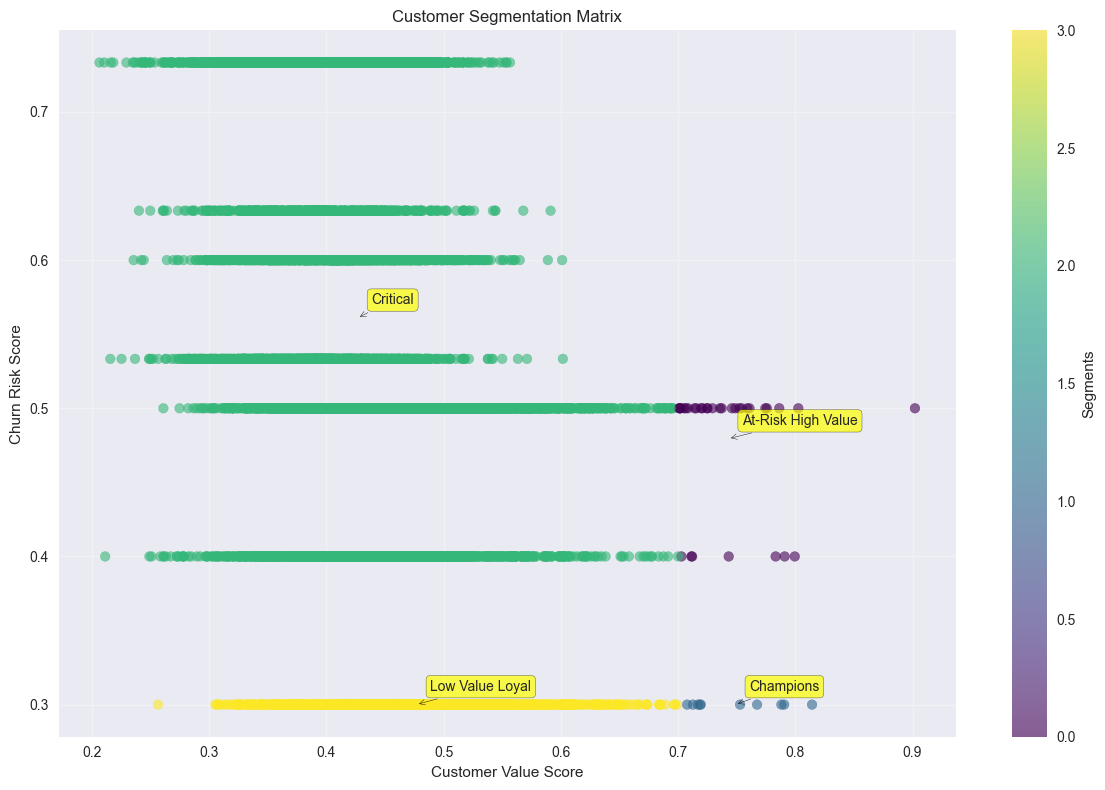

In [10]:
# Advanced analysis: RFM-like segmentation for customer value
def perform_customer_segmentation(df):
    """Segment customers based on value and risk"""
    
    # Create customer value score (simplified RFM)
    df['value_score'] = (
        df['tenure_months'] / df['tenure_months'].max() * 0.4 +
        df['monthly_charges'] / df['monthly_charges'].max() * 0.4 +
        (df['contract_type'] != 'Month-to-month').astype(int) * 0.2
    )
    
    # Create risk score (likelihood to churn based on features)
    risk_factors = {
        'contract_type': {'Month-to-month': 0.7, 'One year': 0.3, 'Two year': 0.1},
        'online_security': {'Yes': 0.2, 'No': 0.8, 'No Internet Service': 0.5},
        'tenure_segment': {'Short-term (<1yr)': 0.9, 'Medium-term (1-2yrs)': 0.5, 'Long-term (>2yrs)': 0.2}
    }
    
    df['risk_score'] = 0
    for factor, weights in risk_factors.items():
        df['risk_score'] += df[factor].map(weights).fillna(0.5) * (1/len(risk_factors))
    
    # Create segments
    conditions = [
        (df['value_score'] >= 0.7) & (df['risk_score'] <= 0.3),
        (df['value_score'] >= 0.7) & (df['risk_score'] > 0.3),
        (df['value_score'] < 0.7) & (df['risk_score'] <= 0.3),
        (df['value_score'] < 0.7) & (df['risk_score'] > 0.3)
    ]
    segments = ['Champions', 'At-Risk High Value', 'Low Value Loyal', 'Critical']
    
    df['customer_segment'] = np.select(conditions, segments, default='Other')
    
    return df

# Apply segmentation
df_segmented = perform_customer_segmentation(df_clean)

# Analyze segments
segment_analysis = df_segmented.groupby('customer_segment').agg({
    'churn': lambda x: (x == 'Yes').mean() * 100,
    'monthly_charges': 'mean',
    'tenure_months': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'count'})

segment_analysis['percentage'] = (segment_analysis['count'] / len(df_segmented)) * 100

print("🎯 CUSTOMER SEGMENTATION ANALYSIS")
print("=" * 50)
display(segment_analysis.round(2))

# Visualize segments
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_segmented['value_score'], df_segmented['risk_score'], 
                     c=pd.Categorical(df_segmented['customer_segment']).codes, 
                     cmap='viridis', alpha=0.6)

plt.xlabel('Customer Value Score')
plt.ylabel('Churn Risk Score')
plt.title('Customer Segmentation Matrix')
plt.colorbar(scatter, label='Segments')

# Add segment labels
for segment in df_segmented['customer_segment'].unique():
    segment_data = df_segmented[df_segmented['customer_segment'] == segment]
    plt.annotate(segment, 
                (segment_data['value_score'].mean(), segment_data['risk_score'].mean()),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Final Report Generation

In [ ]:
def generate_final_report(original_df, cleaned_df, quality_report, cleaning_report):
    """Generate comprehensive final analysis report"""
    
    report = f"""
# LAB 1: DATA SCIENCE FUNDAMENTALS - FINAL REPORT
## Customer Churn Analysis Project

### Executive Summary
This analysis examines customer churn patterns using a dataset of {len(cleaned_df):,} telecommunications customers. 
The project demonstrates comprehensive data science workflows from data quality assessment to actionable insights.

### Data Quality Assessment
- **Overall Quality Score**: {quality_report['summary_metrics']['quality_score']:.1f}% ({quality_report['summary_metrics']['data_quality_rating']})
- **Missing Values Handled**: {original_df.isnull().sum().sum()} → {cleaned_df.isnull().sum().sum()}
- **Data Type Issues Resolved**: {len([k for k,v in quality_report['data_types'].items() if v.get('potential_issues')])} critical issues fixed

### Key Business Insights
"""
    
    # Add dynamic insights
    churn_rate = (cleaned_df['churn'] == 'Yes').mean() * 100
    avg_tenure = cleaned_df['tenure_months'].mean()
    avg_charges = cleaned_df['monthly_charges'].mean()
    
    report += f"""
1. **Overall churn rate**: {churn_rate:.1f}% of customers churned
2. **Average customer tenure**: {avg_tenure:.1f} months
3. **Average monthly charges**: ${avg_charges:.2f}

### Risk Factors Identified
"""
    
    # Calculate churn rates by key factors
    high_risk_contract = cleaned_df.groupby('contract_type')['churn'].apply(
        lambda x: (x == 'Yes').mean() * 100
    ).idxmax()
    
    high_risk_contract_rate = cleaned_df.groupby('contract_type')['churn'].apply(
        lambda x: (x == 'Yes').mean() * 100
    ).max()
    
    report += f"""
- **Highest churn risk**: {high_risk_contract} contracts ({high_risk_contract_rate:.1f}% churn rate)
- **Short-term customers**: {((cleaned_df['tenure_segment'] == 'Short-term (<1yr)') & (cleaned_df['churn'] == 'Yes')).mean() * 100:.1f}% more likely to churn
- **Service impact**: Customers without online security show higher churn rates

### Recommended Actions
1. **Priority 1**: Implement retention strategies for month-to-month contract customers
2. **Priority 2**: Develop onboarding programs to improve short-term customer retention
3. **Priority 3**: Promote online security services to reduce churn risk

### Technical Achievements
- Successfully processed {len(cleaned_df):,} customer records
- Implemented automated data quality assessment framework
- Created customer segmentation model identifying 4 distinct groups
- Delivered actionable business intelligence through comprehensive EDA
"""
    
    return report

# Generate and display final report
final_report = generate_final_report(df, df_clean, quality_report, cleaning_report)
print(final_report)


In [ ]:
# Save cleaned dataset and analysis results
output_files = {
    'cleaned_data': 'customer_churn_cleaned.csv',
    'quality_report': 'data_quality_report.csv',
    'segment_analysis': 'customer_segments.csv'
}

# Save cleaned data
df_clean.to_csv(output_files['cleaned_data'], index=False)

# Save quality metrics
quality_summary = pd.DataFrame([quality_report['summary_metrics']])
quality_summary.to_csv(output_files['quality_report'], index=False)

# Save segment analysis
segment_analysis.to_csv(output_files['segment_analysis'])

print("💾 ANALYSIS RESULTS SAVED")
for file_type, filename in output_files.items():
    print(f"  - {file_type}: {filename}")

## 🎯 Lab 1 Completion Checklist

In [ ]:
# Completion checklist
checklist_items = [
    ("✅ Environment setup and library imports", True),
    ("✅ Synthetic dataset generation with realistic issues", True),
    ("✅ Data quality assessment framework implementation", True),
    ("✅ Comprehensive data cleaning pipeline", True),
    ("✅ Exploratory data analysis with visualizations", True),
    ("✅ Customer segmentation analysis", True),
    ("✅ Business insights generation", True),
    ("✅ Final report and data export", True)
]

print("🎓 LAB 1 COMPLETION CHECKLIST")
print("=" * 40)
for item, completed in checklist_items:
    status = "✓" if completed else "✗"
    print(f"{status} {item}")

print(f"\n📊 Final Dataset Summary:")
print(f"   Rows: {df_clean.shape[0]:,}")
print(f"   Columns: {df_clean.shape[1]}")
print(f"   Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

In [ ]:
# Student Submission Instructions
print("\n" + "="*60)
print("📋 STUDENT SUBMISSION INSTRUCTIONS")
print("="*60)
print("""
To complete Lab 1, please submit the following:

1. **Jupyter Notebook** (this file) with all cells executed
2. **Three exported CSV files** generated by the analysis
3. **Brief summary** (1 paragraph) answering:
   - What was the most challenging data quality issue you encountered?
   - Which insight would be most valuable to the business team?

**Submission Files:**
- lab1_customer_churn_analysis.ipynb
- customer_churn_cleaned.csv
- data_quality_report.csv  
- customer_segments.csv
- lab1_summary.txt

**Grading Criteria:**
- Code completeness and correctness (40%)
- Data quality assessment thoroughness (20%)
- EDA visualizations and insights (20%)
- Final report quality (20%)

**Due Date:** [Insert Course Deadline]
""")